In [1]:
from sklearn.datasets import make_classification

# Generate a 2-class classification dataset with 5 features and 200 instances
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=2, random_state=0)

In [2]:
from AITIA.heuristics import DisjunctSize, DisjunctClass, KNeighbors, ClassLikelihood, RDOS

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [4]:
import numpy as np
from sklearn.metrics import roc_auc_score

In [5]:
misclassifications = [0 if pred == test else 1 for pred, test in zip(y_pred, y_test)]

In [6]:
DS = DisjunctSize()
DS.fit(X_train,y_train)
roc_auc_score(misclassifications,[-x for x in DS.calculate(X_test)])

0.8573057129828675

In [7]:
DS = DisjunctClass()
DS.fit(X_train,y_train)
roc_auc_score(misclassifications,DS.calculate_diversity(X_test))

0.8517034720865089

In [8]:
DS = KNeighbors()
DS.fit(X_train,y_train)
roc_auc_score(misclassifications,DS.calculate_diversity(X_test))

0.8160054719562244

In [9]:
DS = ClassLikelihood()
DS.fit(X_train,y_train)
ec, ev = DS.calculate_evidence_conflict(X_test,return_evidence_volume=True)
roc_auc_score(misclassifications,ec)

0.8617353918311511

In [10]:
rdos = RDOS(n_neighbors=5, h=1)
rdos.fit(X_train)
scores = rdos.calculate(X_test)
roc_auc_score(misclassifications,scores)

0.609406553319002

In [ ]:
def get_normalised_distance(self,X_new,X,y):
        clf = svm.SVC(kernel='linear').fit(X, y)
        desc_func = clf.decision_function(X)
        desc_func_new = clf.decision_function(X_new)
        w_norm = np.linalg.norm(clf.coef_)
        desc_func = desc_func/w_norm
        desc_func_new = desc_func_new/w_norm
        scaler = np.array(desc_func_new/max(desc_func))
        desc_func_new = scaler.reshape(-1,1)
        return desc_func_new

    def Hyperplane_Distance(self, X_new, X, y):
        unq_y = np.unique(y)
        c = list(combinations(unq_y, 2))

        class_idx = []
        for classes in unq_y:
            class_idx.append(np.where(y==classes)[0])

        distances = []
        iter = 0
        for combo in c:
            idx = np.append(class_idx[combo[0]], class_idx[combo[1]])
            distances.append(self.get_normalised_distance(X_new,X[idx],y[idx]))

        min_dist = np.abs(np.nanmin(np.hstack(distances),axis=1))
        return min_dist

In [6]:
from AITIA.heuristics import HyperplaneDistance

In [13]:
hd = HyperplaneDistance()
hd.fit(X_train,y_train)
scores = hd.calculate(X_test)

In [14]:
roc_auc_score(misclassifications,scores)

0.47544303797468357

In [9]:
import matplotlib.pyplot as plt

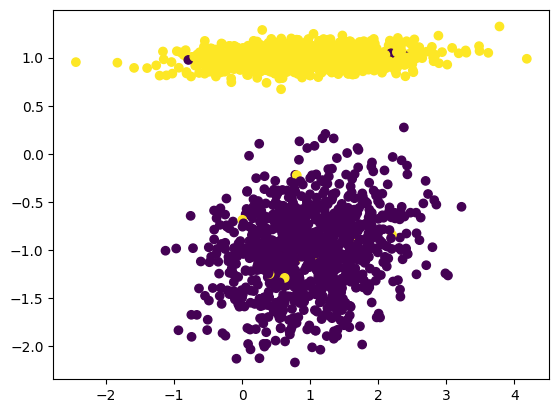

In [10]:
plt.scatter(X[:,0], X[:,1], c=y)

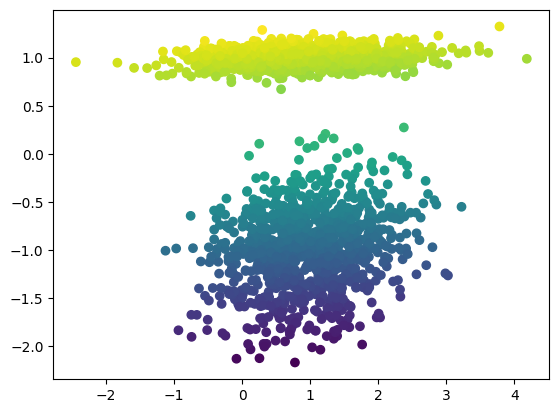

In [11]:
plt.scatter(X[:,0], X[:,1], c=scores)